In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_1_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 831)
(772408, 8)
validation
(101248, 831)
(101248, 8)
test
(98888, 831)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/773 [..............................] - ETA: 14:36 - loss: 1.7370 - STD: 0.0728 - MAE: 0.1999

 16/773 [..............................] - ETA: 2s - loss: 1.3539 - STD: 0.1922 - MAE: 0.1450   

 32/773 [>.............................] - ETA: 2s - loss: 1.3364 - STD: 0.1931 - MAE: 0.1446

 48/773 [>.............................] - ETA: 2s - loss: 1.3257 - STD: 0.1924 - MAE: 0.1447

 63/773 [=>............................] - ETA: 2s - loss: 1.3170 - STD: 0.1923 - MAE: 0.1444

 79/773 [==>...........................] - ETA: 2s - loss: 1.3043 - STD: 0.1935 - MAE: 0.1436

 95/773 [==>...........................] - ETA: 2s - loss: 1.2877 - STD: 0.1947 - MAE: 0.1425

111/773 [===>..........................] - ETA: 2s - loss: 1.2734 - STD: 0.1954 - MAE: 0.1418

127/773 [===>..........................] - ETA: 2s - loss: 1.2571 - STD: 0.1964 - MAE: 0.1409

143/773 [====>.........................] - ETA: 2s - loss: 1.2435 - STD: 0.1973 - MAE: 0.1402

159/773 [=====>........................] - ETA: 2s - loss: 1.2285 - STD: 0.1982 - MAE: 0.1393

174/773 [=====>........................] - ETA: 1s - loss: 1.2141 - STD: 0.1990 - MAE: 0.1385

190/773 [======>.......................] - ETA: 1s - loss: 1.2001 - STD: 0.2000 - MAE: 0.1377

208/773 [=======>......................] - ETA: 1s - loss: 1.1865 - STD: 0.2010 - MAE: 0.1369

225/773 [=======>......................] - ETA: 1s - loss: 1.1726 - STD: 0.2022 - MAE: 0.1359

242/773 [========>.....................] - ETA: 1s - loss: 1.1603 - STD: 0.2032 - MAE: 0.1351

257/773 [========>.....................] - ETA: 1s - loss: 1.1499 - STD: 0.2039 - MAE: 0.1344

269/773 [=========>....................] - ETA: 1s - loss: 1.1405 - STD: 0.2047 - MAE: 0.1338

282/773 [=========>....................] - ETA: 1s - loss: 1.1312 - STD: 0.2055 - MAE: 0.1330

296/773 [==========>...................] - ETA: 1s - loss: 1.1214 - STD: 0.2063 - MAE: 0.1323

310/773 [===========>..................] - ETA: 1s - loss: 1.1124 - STD: 0.2072 - MAE: 0.1316

324/773 [===========>..................] - ETA: 1s - loss: 1.1041 - STD: 0.2079 - MAE: 0.1310

340/773 [============>.................] - ETA: 1s - loss: 1.0949 - STD: 0.2087 - MAE: 0.1303

356/773 [============>.................] - ETA: 1s - loss: 1.0865 - STD: 0.2095 - MAE: 0.1297

369/773 [=============>................] - ETA: 1s - loss: 1.0802 - STD: 0.2101 - MAE: 0.1292

382/773 [=============>................] - ETA: 1s - loss: 1.0745 - STD: 0.2106 - MAE: 0.1288

394/773 [==============>...............] - ETA: 1s - loss: 1.0683 - STD: 0.2112 - MAE: 0.1283

408/773 [==============>...............] - ETA: 1s - loss: 1.0619 - STD: 0.2118 - MAE: 0.1278

422/773 [===============>..............] - ETA: 1s - loss: 1.0566 - STD: 0.2123 - MAE: 0.1273

433/773 [===============>..............] - ETA: 1s - loss: 1.0526 - STD: 0.2127 - MAE: 0.1270

446/773 [================>.............] - ETA: 1s - loss: 1.0478 - STD: 0.2131 - MAE: 0.1266

458/773 [================>.............] - ETA: 1s - loss: 1.0436 - STD: 0.2135 - MAE: 0.1263

470/773 [=================>............] - ETA: 1s - loss: 1.0392 - STD: 0.2139 - MAE: 0.1260

482/773 [=================>............] - ETA: 1s - loss: 1.0353 - STD: 0.2143 - MAE: 0.1256

496/773 [==================>...........] - ETA: 1s - loss: 1.0305 - STD: 0.2148 - MAE: 0.1252

509/773 [==================>...........] - ETA: 1s - loss: 1.0267 - STD: 0.2152 - MAE: 0.1249

521/773 [===================>..........] - ETA: 1s - loss: 1.0233 - STD: 0.2155 - MAE: 0.1247

534/773 [===================>..........] - ETA: 1s - loss: 1.0200 - STD: 0.2158 - MAE: 0.1244

546/773 [====================>.........] - ETA: 1s - loss: 1.0168 - STD: 0.2161 - MAE: 0.1241

559/773 [====================>.........] - ETA: 0s - loss: 1.0135 - STD: 0.2164 - MAE: 0.1239

575/773 [=====================>........] - ETA: 0s - loss: 1.0093 - STD: 0.2168 - MAE: 0.1235

592/773 [=====================>........] - ETA: 0s - loss: 1.0049 - STD: 0.2173 - MAE: 0.1232

608/773 [======================>.......] - ETA: 0s - loss: 1.0010 - STD: 0.2176 - MAE: 0.1228

625/773 [=======================>......] - ETA: 0s - loss: 0.9972 - STD: 0.2180 - MAE: 0.1226

642/773 [=======================>......] - ETA: 0s - loss: 0.9932 - STD: 0.2184 - MAE: 0.1222

658/773 [========================>.....] - ETA: 0s - loss: 0.9897 - STD: 0.2187 - MAE: 0.1219

675/773 [=========================>....] - ETA: 0s - loss: 0.9861 - STD: 0.2191 - MAE: 0.1216

692/773 [=========================>....] - ETA: 0s - loss: 0.9826 - STD: 0.2194 - MAE: 0.1213

708/773 [==========================>...] - ETA: 0s - loss: 0.9799 - STD: 0.2198 - MAE: 0.1211

724/773 [===========================>..] - ETA: 0s - loss: 0.9774 - STD: 0.2200 - MAE: 0.1209

742/773 [===========================>..] - ETA: 0s - loss: 0.9738 - STD: 0.2203 - MAE: 0.1206

759/773 [============================>.] - ETA: 0s - loss: 0.9705 - STD: 0.2207 - MAE: 0.1203

773/773 [==============================] - 5s 5ms/step - loss: 0.9680 - STD: 0.2209 - MAE: 0.1201 - val_loss: 0.8392 - val_STD: 0.2434 - val_MAE: 0.1019


Epoch 2/10000


  1/773 [..............................] - ETA: 15s - loss: 0.8001 - STD: 0.2477 - MAE: 0.0998

 16/773 [..............................] - ETA: 2s - loss: 0.8308 - STD: 0.2356 - MAE: 0.1079 

 29/773 [>.............................] - ETA: 2s - loss: 0.8380 - STD: 0.2345 - MAE: 0.1090

 42/773 [>.............................] - ETA: 2s - loss: 0.8314 - STD: 0.2349 - MAE: 0.1083

 57/773 [=>............................] - ETA: 2s - loss: 0.8286 - STD: 0.2349 - MAE: 0.1082

 73/773 [=>............................] - ETA: 2s - loss: 0.8281 - STD: 0.2348 - MAE: 0.1082

 88/773 [==>...........................] - ETA: 2s - loss: 0.8277 - STD: 0.2348 - MAE: 0.1082

103/773 [==>...........................] - ETA: 2s - loss: 0.8269 - STD: 0.2352 - MAE: 0.1079

117/773 [===>..........................] - ETA: 2s - loss: 0.8258 - STD: 0.2352 - MAE: 0.1078

135/773 [====>.........................] - ETA: 2s - loss: 0.8247 - STD: 0.2353 - MAE: 0.1077

150/773 [====>.........................] - ETA: 2s - loss: 0.8240 - STD: 0.2353 - MAE: 0.1077

163/773 [=====>........................] - ETA: 2s - loss: 0.8250 - STD: 0.2352 - MAE: 0.1078

176/773 [=====>........................] - ETA: 2s - loss: 0.8242 - STD: 0.2351 - MAE: 0.1079

189/773 [======>.......................] - ETA: 2s - loss: 0.8233 - STD: 0.2353 - MAE: 0.1077

205/773 [======>.......................] - ETA: 2s - loss: 0.8216 - STD: 0.2354 - MAE: 0.1076

220/773 [=======>......................] - ETA: 1s - loss: 0.8212 - STD: 0.2354 - MAE: 0.1076

232/773 [========>.....................] - ETA: 1s - loss: 0.8208 - STD: 0.2355 - MAE: 0.1075

245/773 [========>.....................] - ETA: 1s - loss: 0.8214 - STD: 0.2354 - MAE: 0.1076

257/773 [========>.....................] - ETA: 1s - loss: 0.8207 - STD: 0.2354 - MAE: 0.1076

270/773 [=========>....................] - ETA: 1s - loss: 0.8194 - STD: 0.2356 - MAE: 0.1074

284/773 [==========>...................] - ETA: 1s - loss: 0.8185 - STD: 0.2356 - MAE: 0.1074

297/773 [==========>...................] - ETA: 1s - loss: 0.8177 - STD: 0.2358 - MAE: 0.1072

312/773 [===========>..................] - ETA: 1s - loss: 0.8164 - STD: 0.2358 - MAE: 0.1071

324/773 [===========>..................] - ETA: 1s - loss: 0.8154 - STD: 0.2359 - MAE: 0.1071

337/773 [============>.................] - ETA: 1s - loss: 0.8145 - STD: 0.2360 - MAE: 0.1070

353/773 [============>.................] - ETA: 1s - loss: 0.8134 - STD: 0.2361 - MAE: 0.1069

370/773 [=============>................] - ETA: 1s - loss: 0.8127 - STD: 0.2362 - MAE: 0.1068

386/773 [=============>................] - ETA: 1s - loss: 0.8130 - STD: 0.2363 - MAE: 0.1068

400/773 [==============>...............] - ETA: 1s - loss: 0.8131 - STD: 0.2363 - MAE: 0.1068

417/773 [===============>..............] - ETA: 1s - loss: 0.8122 - STD: 0.2364 - MAE: 0.1067

431/773 [===============>..............] - ETA: 1s - loss: 0.8115 - STD: 0.2364 - MAE: 0.1067

444/773 [================>.............] - ETA: 1s - loss: 0.8105 - STD: 0.2365 - MAE: 0.1066

460/773 [================>.............] - ETA: 1s - loss: 0.8095 - STD: 0.2365 - MAE: 0.1065

476/773 [=================>............] - ETA: 1s - loss: 0.8084 - STD: 0.2366 - MAE: 0.1064

491/773 [==================>...........] - ETA: 1s - loss: 0.8074 - STD: 0.2367 - MAE: 0.1063

507/773 [==================>...........] - ETA: 0s - loss: 0.8062 - STD: 0.2368 - MAE: 0.1062

524/773 [===================>..........] - ETA: 0s - loss: 0.8053 - STD: 0.2369 - MAE: 0.1061

540/773 [===================>..........] - ETA: 0s - loss: 0.8041 - STD: 0.2370 - MAE: 0.1060

556/773 [====================>.........] - ETA: 0s - loss: 0.8032 - STD: 0.2371 - MAE: 0.1059

573/773 [=====================>........] - ETA: 0s - loss: 0.8024 - STD: 0.2372 - MAE: 0.1059

589/773 [=====================>........] - ETA: 0s - loss: 0.8020 - STD: 0.2372 - MAE: 0.1059

605/773 [======================>.......] - ETA: 0s - loss: 0.8010 - STD: 0.2373 - MAE: 0.1058

621/773 [=======================>......] - ETA: 0s - loss: 0.7999 - STD: 0.2373 - MAE: 0.1057

637/773 [=======================>......] - ETA: 0s - loss: 0.7994 - STD: 0.2374 - MAE: 0.1056

652/773 [========================>.....] - ETA: 0s - loss: 0.7984 - STD: 0.2375 - MAE: 0.1055

667/773 [========================>.....] - ETA: 0s - loss: 0.7976 - STD: 0.2376 - MAE: 0.1055

683/773 [=========================>....] - ETA: 0s - loss: 0.7971 - STD: 0.2377 - MAE: 0.1054

699/773 [==========================>...] - ETA: 0s - loss: 0.7968 - STD: 0.2377 - MAE: 0.1054

712/773 [==========================>...] - ETA: 0s - loss: 0.7968 - STD: 0.2378 - MAE: 0.1054

724/773 [===========================>..] - ETA: 0s - loss: 0.7964 - STD: 0.2378 - MAE: 0.1053

737/773 [===========================>..] - ETA: 0s - loss: 0.7958 - STD: 0.2378 - MAE: 0.1053

753/773 [============================>.] - ETA: 0s - loss: 0.7952 - STD: 0.2379 - MAE: 0.1052

768/773 [============================>.] - ETA: 0s - loss: 0.7948 - STD: 0.2380 - MAE: 0.1052

773/773 [==============================] - 3s 4ms/step - loss: 0.7946 - STD: 0.2380 - MAE: 0.1052 - val_loss: 0.7914 - val_STD: 0.2377 - val_MAE: 0.1027


Epoch 3/10000


  1/773 [..............................] - ETA: 13s - loss: 0.7863 - STD: 0.2374 - MAE: 0.1058

 16/773 [..............................] - ETA: 2s - loss: 0.7714 - STD: 0.2389 - MAE: 0.1037 

 34/773 [>.............................] - ETA: 2s - loss: 0.7645 - STD: 0.2404 - MAE: 0.1026

 49/773 [>.............................] - ETA: 2s - loss: 0.7672 - STD: 0.2400 - MAE: 0.1030

 61/773 [=>............................] - ETA: 2s - loss: 0.7644 - STD: 0.2400 - MAE: 0.1029

 73/773 [=>............................] - ETA: 2s - loss: 0.7610 - STD: 0.2403 - MAE: 0.1027

 88/773 [==>...........................] - ETA: 2s - loss: 0.7577 - STD: 0.2407 - MAE: 0.1022

103/773 [==>...........................] - ETA: 2s - loss: 0.7561 - STD: 0.2411 - MAE: 0.1019

120/773 [===>..........................] - ETA: 2s - loss: 0.7578 - STD: 0.2410 - MAE: 0.1020

137/773 [====>.........................] - ETA: 2s - loss: 0.7572 - STD: 0.2411 - MAE: 0.1020

154/773 [====>.........................] - ETA: 2s - loss: 0.7573 - STD: 0.2411 - MAE: 0.1020

171/773 [=====>........................] - ETA: 2s - loss: 0.7585 - STD: 0.2411 - MAE: 0.1021

185/773 [======>.......................] - ETA: 1s - loss: 0.7589 - STD: 0.2411 - MAE: 0.1021

201/773 [======>.......................] - ETA: 1s - loss: 0.7576 - STD: 0.2412 - MAE: 0.1020

217/773 [=======>......................] - ETA: 1s - loss: 0.7567 - STD: 0.2414 - MAE: 0.1019

234/773 [========>.....................] - ETA: 1s - loss: 0.7558 - STD: 0.2414 - MAE: 0.1018

252/773 [========>.....................] - ETA: 1s - loss: 0.7556 - STD: 0.2414 - MAE: 0.1018

269/773 [=========>....................] - ETA: 1s - loss: 0.7543 - STD: 0.2415 - MAE: 0.1017

285/773 [==========>...................] - ETA: 1s - loss: 0.7534 - STD: 0.2417 - MAE: 0.1015

301/773 [==========>...................] - ETA: 1s - loss: 0.7529 - STD: 0.2417 - MAE: 0.1015

319/773 [===========>..................] - ETA: 1s - loss: 0.7525 - STD: 0.2418 - MAE: 0.1015

336/773 [============>.................] - ETA: 1s - loss: 0.7522 - STD: 0.2418 - MAE: 0.1014

351/773 [============>.................] - ETA: 1s - loss: 0.7526 - STD: 0.2418 - MAE: 0.1014

366/773 [=============>................] - ETA: 1s - loss: 0.7515 - STD: 0.2419 - MAE: 0.1013

382/773 [=============>................] - ETA: 1s - loss: 0.7511 - STD: 0.2419 - MAE: 0.1013

399/773 [==============>...............] - ETA: 1s - loss: 0.7504 - STD: 0.2420 - MAE: 0.1012

416/773 [===============>..............] - ETA: 1s - loss: 0.7493 - STD: 0.2421 - MAE: 0.1011

431/773 [===============>..............] - ETA: 1s - loss: 0.7488 - STD: 0.2422 - MAE: 0.1010

444/773 [================>.............] - ETA: 1s - loss: 0.7487 - STD: 0.2422 - MAE: 0.1010

461/773 [================>.............] - ETA: 1s - loss: 0.7488 - STD: 0.2423 - MAE: 0.1010

477/773 [=================>............] - ETA: 0s - loss: 0.7486 - STD: 0.2422 - MAE: 0.1011

493/773 [==================>...........] - ETA: 0s - loss: 0.7479 - STD: 0.2423 - MAE: 0.1010

509/773 [==================>...........] - ETA: 0s - loss: 0.7483 - STD: 0.2423 - MAE: 0.1010

524/773 [===================>..........] - ETA: 0s - loss: 0.7480 - STD: 0.2423 - MAE: 0.1010

541/773 [===================>..........] - ETA: 0s - loss: 0.7475 - STD: 0.2424 - MAE: 0.1009

558/773 [====================>.........] - ETA: 0s - loss: 0.7471 - STD: 0.2425 - MAE: 0.1008

571/773 [=====================>........] - ETA: 0s - loss: 0.7462 - STD: 0.2425 - MAE: 0.1008

587/773 [=====================>........] - ETA: 0s - loss: 0.7457 - STD: 0.2426 - MAE: 0.1007

602/773 [======================>.......] - ETA: 0s - loss: 0.7456 - STD: 0.2426 - MAE: 0.1007

618/773 [======================>.......] - ETA: 0s - loss: 0.7452 - STD: 0.2426 - MAE: 0.1007

630/773 [=======================>......] - ETA: 0s - loss: 0.7450 - STD: 0.2426 - MAE: 0.1007

646/773 [========================>.....] - ETA: 0s - loss: 0.7447 - STD: 0.2427 - MAE: 0.1006

663/773 [========================>.....] - ETA: 0s - loss: 0.7445 - STD: 0.2427 - MAE: 0.1006

678/773 [=========================>....] - ETA: 0s - loss: 0.7443 - STD: 0.2427 - MAE: 0.1006

694/773 [=========================>....] - ETA: 0s - loss: 0.7442 - STD: 0.2428 - MAE: 0.1006

711/773 [==========================>...] - ETA: 0s - loss: 0.7439 - STD: 0.2428 - MAE: 0.1005

728/773 [===========================>..] - ETA: 0s - loss: 0.7437 - STD: 0.2428 - MAE: 0.1005

744/773 [===========================>..] - ETA: 0s - loss: 0.7435 - STD: 0.2428 - MAE: 0.1005

761/773 [============================>.] - ETA: 0s - loss: 0.7432 - STD: 0.2429 - MAE: 0.1005

773/773 [==============================] - 3s 4ms/step - loss: 0.7430 - STD: 0.2429 - MAE: 0.1004 - val_loss: 0.7478 - val_STD: 0.2532 - val_MAE: 0.0940


Epoch 4/10000


  1/773 [..............................] - ETA: 20s - loss: 0.7493 - STD: 0.2541 - MAE: 0.0960

 14/773 [..............................] - ETA: 2s - loss: 0.7324 - STD: 0.2453 - MAE: 0.0992 

 30/773 [>.............................] - ETA: 2s - loss: 0.7351 - STD: 0.2436 - MAE: 0.1001

 46/773 [>.............................] - ETA: 2s - loss: 0.7341 - STD: 0.2440 - MAE: 0.0997

 62/773 [=>............................] - ETA: 2s - loss: 0.7358 - STD: 0.2432 - MAE: 0.1001

 78/773 [==>...........................] - ETA: 2s - loss: 0.7301 - STD: 0.2438 - MAE: 0.0995

 95/773 [==>...........................] - ETA: 2s - loss: 0.7309 - STD: 0.2441 - MAE: 0.0995

112/773 [===>..........................] - ETA: 2s - loss: 0.7297 - STD: 0.2442 - MAE: 0.0993

125/773 [===>..........................] - ETA: 2s - loss: 0.7275 - STD: 0.2444 - MAE: 0.0991

137/773 [====>.........................] - ETA: 2s - loss: 0.7265 - STD: 0.2445 - MAE: 0.0990

149/773 [====>.........................] - ETA: 2s - loss: 0.7258 - STD: 0.2446 - MAE: 0.0989

161/773 [=====>........................] - ETA: 2s - loss: 0.7266 - STD: 0.2445 - MAE: 0.0990

173/773 [=====>........................] - ETA: 2s - loss: 0.7279 - STD: 0.2445 - MAE: 0.0990

185/773 [======>.......................] - ETA: 2s - loss: 0.7299 - STD: 0.2445 - MAE: 0.0991

197/773 [======>.......................] - ETA: 2s - loss: 0.7299 - STD: 0.2445 - MAE: 0.0991

209/773 [=======>......................] - ETA: 2s - loss: 0.7289 - STD: 0.2445 - MAE: 0.0991

221/773 [=======>......................] - ETA: 2s - loss: 0.7289 - STD: 0.2445 - MAE: 0.0991

233/773 [========>.....................] - ETA: 2s - loss: 0.7280 - STD: 0.2445 - MAE: 0.0990

245/773 [========>.....................] - ETA: 2s - loss: 0.7272 - STD: 0.2446 - MAE: 0.0989

257/773 [========>.....................] - ETA: 1s - loss: 0.7267 - STD: 0.2446 - MAE: 0.0988

269/773 [=========>....................] - ETA: 1s - loss: 0.7268 - STD: 0.2446 - MAE: 0.0989

282/773 [=========>....................] - ETA: 1s - loss: 0.7267 - STD: 0.2446 - MAE: 0.0989

294/773 [==========>...................] - ETA: 1s - loss: 0.7265 - STD: 0.2446 - MAE: 0.0989

307/773 [==========>...................] - ETA: 1s - loss: 0.7267 - STD: 0.2446 - MAE: 0.0989

324/773 [===========>..................] - ETA: 1s - loss: 0.7261 - STD: 0.2446 - MAE: 0.0989

341/773 [============>.................] - ETA: 1s - loss: 0.7254 - STD: 0.2446 - MAE: 0.0988

357/773 [============>.................] - ETA: 1s - loss: 0.7249 - STD: 0.2447 - MAE: 0.0987

369/773 [=============>................] - ETA: 1s - loss: 0.7248 - STD: 0.2448 - MAE: 0.0987

382/773 [=============>................] - ETA: 1s - loss: 0.7246 - STD: 0.2448 - MAE: 0.0987

394/773 [==============>...............] - ETA: 1s - loss: 0.7248 - STD: 0.2448 - MAE: 0.0987

407/773 [==============>...............] - ETA: 1s - loss: 0.7246 - STD: 0.2448 - MAE: 0.0986

420/773 [===============>..............] - ETA: 1s - loss: 0.7245 - STD: 0.2449 - MAE: 0.0986

435/773 [===============>..............] - ETA: 1s - loss: 0.7238 - STD: 0.2449 - MAE: 0.0986

447/773 [================>.............] - ETA: 1s - loss: 0.7234 - STD: 0.2449 - MAE: 0.0985

462/773 [================>.............] - ETA: 1s - loss: 0.7230 - STD: 0.2450 - MAE: 0.0985

477/773 [=================>............] - ETA: 1s - loss: 0.7227 - STD: 0.2450 - MAE: 0.0984

491/773 [==================>...........] - ETA: 1s - loss: 0.7223 - STD: 0.2450 - MAE: 0.0984

503/773 [==================>...........] - ETA: 1s - loss: 0.7220 - STD: 0.2451 - MAE: 0.0984

518/773 [===================>..........] - ETA: 0s - loss: 0.7217 - STD: 0.2451 - MAE: 0.0983

533/773 [===================>..........] - ETA: 0s - loss: 0.7216 - STD: 0.2452 - MAE: 0.0983

547/773 [====================>.........] - ETA: 0s - loss: 0.7217 - STD: 0.2452 - MAE: 0.0983

560/773 [====================>.........] - ETA: 0s - loss: 0.7210 - STD: 0.2452 - MAE: 0.0982

575/773 [=====================>........] - ETA: 0s - loss: 0.7206 - STD: 0.2453 - MAE: 0.0982

590/773 [=====================>........] - ETA: 0s - loss: 0.7204 - STD: 0.2453 - MAE: 0.0982

605/773 [======================>.......] - ETA: 0s - loss: 0.7202 - STD: 0.2453 - MAE: 0.0982

620/773 [=======================>......] - ETA: 0s - loss: 0.7199 - STD: 0.2453 - MAE: 0.0981

637/773 [=======================>......] - ETA: 0s - loss: 0.7196 - STD: 0.2454 - MAE: 0.0981

652/773 [========================>.....] - ETA: 0s - loss: 0.7192 - STD: 0.2454 - MAE: 0.0981

663/773 [========================>.....] - ETA: 0s - loss: 0.7190 - STD: 0.2454 - MAE: 0.0980

674/773 [=========================>....] - ETA: 0s - loss: 0.7188 - STD: 0.2455 - MAE: 0.0980

686/773 [=========================>....] - ETA: 0s - loss: 0.7185 - STD: 0.2455 - MAE: 0.0980

698/773 [==========================>...] - ETA: 0s - loss: 0.7182 - STD: 0.2455 - MAE: 0.0979

711/773 [==========================>...] - ETA: 0s - loss: 0.7177 - STD: 0.2456 - MAE: 0.0979

723/773 [===========================>..] - ETA: 0s - loss: 0.7172 - STD: 0.2457 - MAE: 0.0978

735/773 [===========================>..] - ETA: 0s - loss: 0.7169 - STD: 0.2457 - MAE: 0.0978

748/773 [============================>.] - ETA: 0s - loss: 0.7165 - STD: 0.2457 - MAE: 0.0978

760/773 [============================>.] - ETA: 0s - loss: 0.7164 - STD: 0.2458 - MAE: 0.0977

773/773 [==============================] - ETA: 0s - loss: 0.7164 - STD: 0.2458 - MAE: 0.0977

773/773 [==============================] - 3s 4ms/step - loss: 0.7164 - STD: 0.2458 - MAE: 0.0977 - val_loss: 0.7383 - val_STD: 0.2442 - val_MAE: 0.0977


Epoch 5/10000


  1/773 [..............................] - ETA: 15s - loss: 0.7224 - STD: 0.2459 - MAE: 0.0979

 17/773 [..............................] - ETA: 2s - loss: 0.6946 - STD: 0.2467 - MAE: 0.0963 

 34/773 [>.............................] - ETA: 2s - loss: 0.6950 - STD: 0.2472 - MAE: 0.0961

 51/773 [>.............................] - ETA: 2s - loss: 0.7057 - STD: 0.2472 - MAE: 0.0966

 68/773 [=>............................] - ETA: 2s - loss: 0.7090 - STD: 0.2469 - MAE: 0.0969

 85/773 [==>...........................] - ETA: 2s - loss: 0.7070 - STD: 0.2469 - MAE: 0.0967

102/773 [==>...........................] - ETA: 2s - loss: 0.7077 - STD: 0.2470 - MAE: 0.0967

120/773 [===>..........................] - ETA: 1s - loss: 0.7087 - STD: 0.2468 - MAE: 0.0969

136/773 [====>.........................] - ETA: 1s - loss: 0.7059 - STD: 0.2467 - MAE: 0.0967

153/773 [====>.........................] - ETA: 1s - loss: 0.7057 - STD: 0.2469 - MAE: 0.0967

170/773 [=====>........................] - ETA: 1s - loss: 0.7041 - STD: 0.2469 - MAE: 0.0966

187/773 [======>.......................] - ETA: 1s - loss: 0.7027 - STD: 0.2470 - MAE: 0.0964

204/773 [======>.......................] - ETA: 1s - loss: 0.7010 - STD: 0.2472 - MAE: 0.0962

221/773 [=======>......................] - ETA: 1s - loss: 0.6997 - STD: 0.2473 - MAE: 0.0961

238/773 [========>.....................] - ETA: 1s - loss: 0.6985 - STD: 0.2474 - MAE: 0.0960

255/773 [========>.....................] - ETA: 1s - loss: 0.6992 - STD: 0.2474 - MAE: 0.0960

272/773 [=========>....................] - ETA: 1s - loss: 0.6991 - STD: 0.2475 - MAE: 0.0960

289/773 [==========>...................] - ETA: 1s - loss: 0.6984 - STD: 0.2476 - MAE: 0.0959

306/773 [==========>...................] - ETA: 1s - loss: 0.6980 - STD: 0.2476 - MAE: 0.0959

323/773 [===========>..................] - ETA: 1s - loss: 0.6975 - STD: 0.2477 - MAE: 0.0958

339/773 [============>.................] - ETA: 1s - loss: 0.6973 - STD: 0.2477 - MAE: 0.0958

356/773 [============>.................] - ETA: 1s - loss: 0.6969 - STD: 0.2477 - MAE: 0.0958

374/773 [=============>................] - ETA: 1s - loss: 0.6973 - STD: 0.2477 - MAE: 0.0958

391/773 [==============>...............] - ETA: 1s - loss: 0.6973 - STD: 0.2477 - MAE: 0.0958

408/773 [==============>...............] - ETA: 1s - loss: 0.6971 - STD: 0.2476 - MAE: 0.0958

426/773 [===============>..............] - ETA: 1s - loss: 0.6966 - STD: 0.2477 - MAE: 0.0958

443/773 [================>.............] - ETA: 0s - loss: 0.6960 - STD: 0.2477 - MAE: 0.0957

459/773 [================>.............] - ETA: 0s - loss: 0.6961 - STD: 0.2478 - MAE: 0.0957

477/773 [=================>............] - ETA: 0s - loss: 0.6960 - STD: 0.2478 - MAE: 0.0957

493/773 [==================>...........] - ETA: 0s - loss: 0.6957 - STD: 0.2478 - MAE: 0.0957

509/773 [==================>...........] - ETA: 0s - loss: 0.6957 - STD: 0.2478 - MAE: 0.0957

524/773 [===================>..........] - ETA: 0s - loss: 0.6958 - STD: 0.2479 - MAE: 0.0957

536/773 [===================>..........] - ETA: 0s - loss: 0.6955 - STD: 0.2478 - MAE: 0.0957

548/773 [====================>.........] - ETA: 0s - loss: 0.6950 - STD: 0.2479 - MAE: 0.0956

562/773 [====================>.........] - ETA: 0s - loss: 0.6947 - STD: 0.2479 - MAE: 0.0956

576/773 [=====================>........] - ETA: 0s - loss: 0.6945 - STD: 0.2480 - MAE: 0.0955

592/773 [=====================>........] - ETA: 0s - loss: 0.6941 - STD: 0.2480 - MAE: 0.0955

604/773 [======================>.......] - ETA: 0s - loss: 0.6939 - STD: 0.2480 - MAE: 0.0955

616/773 [======================>.......] - ETA: 0s - loss: 0.6936 - STD: 0.2480 - MAE: 0.0955

628/773 [=======================>......] - ETA: 0s - loss: 0.6935 - STD: 0.2480 - MAE: 0.0955

642/773 [=======================>......] - ETA: 0s - loss: 0.6934 - STD: 0.2481 - MAE: 0.0954

655/773 [========================>.....] - ETA: 0s - loss: 0.6935 - STD: 0.2480 - MAE: 0.0955

667/773 [========================>.....] - ETA: 0s - loss: 0.6936 - STD: 0.2481 - MAE: 0.0954

682/773 [=========================>....] - ETA: 0s - loss: 0.6937 - STD: 0.2481 - MAE: 0.0954

698/773 [==========================>...] - ETA: 0s - loss: 0.6935 - STD: 0.2481 - MAE: 0.0954

710/773 [==========================>...] - ETA: 0s - loss: 0.6934 - STD: 0.2481 - MAE: 0.0954

723/773 [===========================>..] - ETA: 0s - loss: 0.6931 - STD: 0.2481 - MAE: 0.0954

735/773 [===========================>..] - ETA: 0s - loss: 0.6926 - STD: 0.2482 - MAE: 0.0953

750/773 [============================>.] - ETA: 0s - loss: 0.6922 - STD: 0.2482 - MAE: 0.0953

766/773 [============================>.] - ETA: 0s - loss: 0.6923 - STD: 0.2482 - MAE: 0.0953

773/773 [==============================] - 3s 4ms/step - loss: 0.6924 - STD: 0.2483 - MAE: 0.0953 - val_loss: 0.7615 - val_STD: 0.2464 - val_MAE: 0.0979


Epoch 6/10000


  1/773 [..............................] - ETA: 21s - loss: 0.6584 - STD: 0.2482 - MAE: 0.0928

 14/773 [..............................] - ETA: 3s - loss: 0.6721 - STD: 0.2478 - MAE: 0.0941 

 30/773 [>.............................] - ETA: 2s - loss: 0.6766 - STD: 0.2492 - MAE: 0.0938

 45/773 [>.............................] - ETA: 2s - loss: 0.6766 - STD: 0.2494 - MAE: 0.0937

 60/773 [=>............................] - ETA: 2s - loss: 0.6756 - STD: 0.2495 - MAE: 0.0936

 73/773 [=>............................] - ETA: 2s - loss: 0.6772 - STD: 0.2496 - MAE: 0.0937

 86/773 [==>...........................] - ETA: 2s - loss: 0.6788 - STD: 0.2494 - MAE: 0.0939

 99/773 [==>...........................] - ETA: 2s - loss: 0.6782 - STD: 0.2495 - MAE: 0.0938

112/773 [===>..........................] - ETA: 2s - loss: 0.6781 - STD: 0.2497 - MAE: 0.0937

125/773 [===>..........................] - ETA: 2s - loss: 0.6785 - STD: 0.2496 - MAE: 0.0938

138/773 [====>.........................] - ETA: 2s - loss: 0.6781 - STD: 0.2497 - MAE: 0.0937

153/773 [====>.........................] - ETA: 2s - loss: 0.6781 - STD: 0.2496 - MAE: 0.0938

169/773 [=====>........................] - ETA: 2s - loss: 0.6777 - STD: 0.2496 - MAE: 0.0938

182/773 [======>.......................] - ETA: 2s - loss: 0.6786 - STD: 0.2495 - MAE: 0.0938

194/773 [======>.......................] - ETA: 2s - loss: 0.6793 - STD: 0.2495 - MAE: 0.0939

207/773 [=======>......................] - ETA: 2s - loss: 0.6783 - STD: 0.2495 - MAE: 0.0938

223/773 [=======>......................] - ETA: 2s - loss: 0.6780 - STD: 0.2496 - MAE: 0.0938

238/773 [========>.....................] - ETA: 2s - loss: 0.6767 - STD: 0.2497 - MAE: 0.0937

254/773 [========>.....................] - ETA: 1s - loss: 0.6764 - STD: 0.2498 - MAE: 0.0936

267/773 [=========>....................] - ETA: 1s - loss: 0.6767 - STD: 0.2498 - MAE: 0.0936

283/773 [=========>....................] - ETA: 1s - loss: 0.6762 - STD: 0.2499 - MAE: 0.0935

296/773 [==========>...................] - ETA: 1s - loss: 0.6761 - STD: 0.2499 - MAE: 0.0935

308/773 [==========>...................] - ETA: 1s - loss: 0.6764 - STD: 0.2499 - MAE: 0.0935

320/773 [===========>..................] - ETA: 1s - loss: 0.6767 - STD: 0.2499 - MAE: 0.0936

333/773 [===========>..................] - ETA: 1s - loss: 0.6767 - STD: 0.2499 - MAE: 0.0936

345/773 [============>.................] - ETA: 1s - loss: 0.6764 - STD: 0.2499 - MAE: 0.0935

357/773 [============>.................] - ETA: 1s - loss: 0.6766 - STD: 0.2499 - MAE: 0.0935

369/773 [=============>................] - ETA: 1s - loss: 0.6768 - STD: 0.2499 - MAE: 0.0936

381/773 [=============>................] - ETA: 1s - loss: 0.6766 - STD: 0.2499 - MAE: 0.0936

393/773 [==============>...............] - ETA: 1s - loss: 0.6765 - STD: 0.2499 - MAE: 0.0936

406/773 [==============>...............] - ETA: 1s - loss: 0.6757 - STD: 0.2499 - MAE: 0.0935

423/773 [===============>..............] - ETA: 1s - loss: 0.6754 - STD: 0.2500 - MAE: 0.0935

439/773 [================>.............] - ETA: 1s - loss: 0.6751 - STD: 0.2500 - MAE: 0.0934

453/773 [================>.............] - ETA: 1s - loss: 0.6754 - STD: 0.2500 - MAE: 0.0934

468/773 [=================>............] - ETA: 1s - loss: 0.6752 - STD: 0.2500 - MAE: 0.0934

484/773 [=================>............] - ETA: 1s - loss: 0.6752 - STD: 0.2500 - MAE: 0.0934

497/773 [==================>...........] - ETA: 1s - loss: 0.6751 - STD: 0.2500 - MAE: 0.0934

512/773 [==================>...........] - ETA: 0s - loss: 0.6757 - STD: 0.2500 - MAE: 0.0935

527/773 [===================>..........] - ETA: 0s - loss: 0.6756 - STD: 0.2500 - MAE: 0.0935

540/773 [===================>..........] - ETA: 0s - loss: 0.6758 - STD: 0.2500 - MAE: 0.0935

554/773 [====================>.........] - ETA: 0s - loss: 0.6754 - STD: 0.2500 - MAE: 0.0935

570/773 [=====================>........] - ETA: 0s - loss: 0.6749 - STD: 0.2500 - MAE: 0.0934

586/773 [=====================>........] - ETA: 0s - loss: 0.6746 - STD: 0.2500 - MAE: 0.0934

604/773 [======================>.......] - ETA: 0s - loss: 0.6748 - STD: 0.2501 - MAE: 0.0934

621/773 [=======================>......] - ETA: 0s - loss: 0.6743 - STD: 0.2501 - MAE: 0.0933

637/773 [=======================>......] - ETA: 0s - loss: 0.6741 - STD: 0.2501 - MAE: 0.0933

651/773 [========================>.....] - ETA: 0s - loss: 0.6743 - STD: 0.2501 - MAE: 0.0933

664/773 [========================>.....] - ETA: 0s - loss: 0.6747 - STD: 0.2501 - MAE: 0.0934

677/773 [=========================>....] - ETA: 0s - loss: 0.6749 - STD: 0.2501 - MAE: 0.0934

690/773 [=========================>....] - ETA: 0s - loss: 0.6747 - STD: 0.2501 - MAE: 0.0934

706/773 [==========================>...] - ETA: 0s - loss: 0.6746 - STD: 0.2501 - MAE: 0.0934

723/773 [===========================>..] - ETA: 0s - loss: 0.6741 - STD: 0.2501 - MAE: 0.0934

740/773 [===========================>..] - ETA: 0s - loss: 0.6738 - STD: 0.2501 - MAE: 0.0933

757/773 [============================>.] - ETA: 0s - loss: 0.6734 - STD: 0.2502 - MAE: 0.0933

773/773 [==============================] - 3s 4ms/step - loss: 0.6733 - STD: 0.2502 - MAE: 0.0933 - val_loss: 0.7289 - val_STD: 0.2462 - val_MAE: 0.0966


Epoch 7/10000


  1/773 [..............................] - ETA: 14s - loss: 0.6570 - STD: 0.2477 - MAE: 0.0943

 14/773 [..............................] - ETA: 2s - loss: 0.6562 - STD: 0.2514 - MAE: 0.0919 

 27/773 [>.............................] - ETA: 2s - loss: 0.6587 - STD: 0.2509 - MAE: 0.0922

 43/773 [>.............................] - ETA: 2s - loss: 0.6594 - STD: 0.2511 - MAE: 0.0922

 59/773 [=>............................] - ETA: 2s - loss: 0.6576 - STD: 0.2515 - MAE: 0.0918

 75/773 [=>............................] - ETA: 2s - loss: 0.6610 - STD: 0.2514 - MAE: 0.0921

 92/773 [==>...........................] - ETA: 2s - loss: 0.6637 - STD: 0.2512 - MAE: 0.0923

109/773 [===>..........................] - ETA: 2s - loss: 0.6645 - STD: 0.2513 - MAE: 0.0923

125/773 [===>..........................] - ETA: 2s - loss: 0.6642 - STD: 0.2513 - MAE: 0.0923

142/773 [====>.........................] - ETA: 2s - loss: 0.6645 - STD: 0.2513 - MAE: 0.0922

158/773 [=====>........................] - ETA: 2s - loss: 0.6638 - STD: 0.2514 - MAE: 0.0921

175/773 [=====>........................] - ETA: 1s - loss: 0.6633 - STD: 0.2513 - MAE: 0.0922

191/773 [======>.......................] - ETA: 1s - loss: 0.6645 - STD: 0.2512 - MAE: 0.0923

206/773 [======>.......................] - ETA: 1s - loss: 0.6655 - STD: 0.2512 - MAE: 0.0924

218/773 [=======>......................] - ETA: 1s - loss: 0.6649 - STD: 0.2512 - MAE: 0.0924

229/773 [=======>......................] - ETA: 1s - loss: 0.6644 - STD: 0.2511 - MAE: 0.0923

242/773 [========>.....................] - ETA: 1s - loss: 0.6638 - STD: 0.2512 - MAE: 0.0923

255/773 [========>.....................] - ETA: 1s - loss: 0.6643 - STD: 0.2512 - MAE: 0.0923

271/773 [=========>....................] - ETA: 1s - loss: 0.6640 - STD: 0.2512 - MAE: 0.0923

288/773 [==========>...................] - ETA: 1s - loss: 0.6636 - STD: 0.2513 - MAE: 0.0922

303/773 [==========>...................] - ETA: 1s - loss: 0.6634 - STD: 0.2513 - MAE: 0.0922

317/773 [===========>..................] - ETA: 1s - loss: 0.6633 - STD: 0.2514 - MAE: 0.0921

329/773 [===========>..................] - ETA: 1s - loss: 0.6630 - STD: 0.2514 - MAE: 0.0921

342/773 [============>.................] - ETA: 1s - loss: 0.6621 - STD: 0.2515 - MAE: 0.0920

358/773 [============>.................] - ETA: 1s - loss: 0.6620 - STD: 0.2515 - MAE: 0.0920

373/773 [=============>................] - ETA: 1s - loss: 0.6614 - STD: 0.2515 - MAE: 0.0919

386/773 [=============>................] - ETA: 1s - loss: 0.6611 - STD: 0.2516 - MAE: 0.0919

403/773 [==============>...............] - ETA: 1s - loss: 0.6604 - STD: 0.2516 - MAE: 0.0918

420/773 [===============>..............] - ETA: 1s - loss: 0.6603 - STD: 0.2516 - MAE: 0.0918

437/773 [===============>..............] - ETA: 1s - loss: 0.6602 - STD: 0.2516 - MAE: 0.0918

453/773 [================>.............] - ETA: 1s - loss: 0.6606 - STD: 0.2517 - MAE: 0.0918

470/773 [=================>............] - ETA: 1s - loss: 0.6606 - STD: 0.2516 - MAE: 0.0919

486/773 [=================>............] - ETA: 0s - loss: 0.6604 - STD: 0.2516 - MAE: 0.0919

501/773 [==================>...........] - ETA: 0s - loss: 0.6604 - STD: 0.2516 - MAE: 0.0918

518/773 [===================>..........] - ETA: 0s - loss: 0.6605 - STD: 0.2516 - MAE: 0.0918

535/773 [===================>..........] - ETA: 0s - loss: 0.6603 - STD: 0.2516 - MAE: 0.0918

551/773 [====================>.........] - ETA: 0s - loss: 0.6600 - STD: 0.2516 - MAE: 0.0918

564/773 [====================>.........] - ETA: 0s - loss: 0.6598 - STD: 0.2516 - MAE: 0.0918

580/773 [=====================>........] - ETA: 0s - loss: 0.6594 - STD: 0.2517 - MAE: 0.0918

596/773 [======================>.......] - ETA: 0s - loss: 0.6597 - STD: 0.2517 - MAE: 0.0918

611/773 [======================>.......] - ETA: 0s - loss: 0.6602 - STD: 0.2517 - MAE: 0.0918

625/773 [=======================>......] - ETA: 0s - loss: 0.6599 - STD: 0.2517 - MAE: 0.0918

638/773 [=======================>......] - ETA: 0s - loss: 0.6594 - STD: 0.2517 - MAE: 0.0918

651/773 [========================>.....] - ETA: 0s - loss: 0.6593 - STD: 0.2517 - MAE: 0.0918

663/773 [========================>.....] - ETA: 0s - loss: 0.6587 - STD: 0.2517 - MAE: 0.0917

676/773 [=========================>....] - ETA: 0s - loss: 0.6582 - STD: 0.2518 - MAE: 0.0916

689/773 [=========================>....] - ETA: 0s - loss: 0.6581 - STD: 0.2518 - MAE: 0.0916

702/773 [==========================>...] - ETA: 0s - loss: 0.6579 - STD: 0.2518 - MAE: 0.0916

714/773 [==========================>...] - ETA: 0s - loss: 0.6580 - STD: 0.2518 - MAE: 0.0916

726/773 [===========================>..] - ETA: 0s - loss: 0.6581 - STD: 0.2518 - MAE: 0.0916

740/773 [===========================>..] - ETA: 0s - loss: 0.6580 - STD: 0.2519 - MAE: 0.0916

755/773 [============================>.] - ETA: 0s - loss: 0.6577 - STD: 0.2519 - MAE: 0.0916

772/773 [============================>.] - ETA: 0s - loss: 0.6572 - STD: 0.2519 - MAE: 0.0915

773/773 [==============================] - 3s 4ms/step - loss: 0.6571 - STD: 0.2519 - MAE: 0.0915 - val_loss: 0.7522 - val_STD: 0.2624 - val_MAE: 0.0895


Epoch 8/10000


  1/773 [..............................] - ETA: 13s - loss: 0.6602 - STD: 0.2616 - MAE: 0.0862

 17/773 [..............................] - ETA: 2s - loss: 0.6646 - STD: 0.2520 - MAE: 0.0920 

 34/773 [>.............................] - ETA: 2s - loss: 0.6498 - STD: 0.2528 - MAE: 0.0907

 50/773 [>.............................] - ETA: 2s - loss: 0.6477 - STD: 0.2531 - MAE: 0.0904

 66/773 [=>............................] - ETA: 2s - loss: 0.6461 - STD: 0.2535 - MAE: 0.0901

 82/773 [==>...........................] - ETA: 2s - loss: 0.6462 - STD: 0.2532 - MAE: 0.0903

 97/773 [==>...........................] - ETA: 2s - loss: 0.6468 - STD: 0.2532 - MAE: 0.0903

113/773 [===>..........................] - ETA: 2s - loss: 0.6457 - STD: 0.2533 - MAE: 0.0901

129/773 [====>.........................] - ETA: 2s - loss: 0.6443 - STD: 0.2535 - MAE: 0.0900

145/773 [====>.........................] - ETA: 2s - loss: 0.6441 - STD: 0.2535 - MAE: 0.0899

162/773 [=====>........................] - ETA: 1s - loss: 0.6442 - STD: 0.2534 - MAE: 0.0900

177/773 [=====>........................] - ETA: 1s - loss: 0.6448 - STD: 0.2534 - MAE: 0.0901

193/773 [======>.......................] - ETA: 1s - loss: 0.6470 - STD: 0.2532 - MAE: 0.0903

209/773 [=======>......................] - ETA: 1s - loss: 0.6469 - STD: 0.2533 - MAE: 0.0903

226/773 [=======>......................] - ETA: 1s - loss: 0.6472 - STD: 0.2531 - MAE: 0.0904

243/773 [========>.....................] - ETA: 1s - loss: 0.6474 - STD: 0.2532 - MAE: 0.0904

257/773 [========>.....................] - ETA: 1s - loss: 0.6471 - STD: 0.2531 - MAE: 0.0904

269/773 [=========>....................] - ETA: 1s - loss: 0.6462 - STD: 0.2532 - MAE: 0.0903

282/773 [=========>....................] - ETA: 1s - loss: 0.6458 - STD: 0.2533 - MAE: 0.0902

297/773 [==========>...................] - ETA: 1s - loss: 0.6451 - STD: 0.2533 - MAE: 0.0901

311/773 [===========>..................] - ETA: 1s - loss: 0.6448 - STD: 0.2533 - MAE: 0.0901

324/773 [===========>..................] - ETA: 1s - loss: 0.6440 - STD: 0.2534 - MAE: 0.0900

338/773 [============>.................] - ETA: 1s - loss: 0.6441 - STD: 0.2534 - MAE: 0.0900

354/773 [============>.................] - ETA: 1s - loss: 0.6442 - STD: 0.2533 - MAE: 0.0900

370/773 [=============>................] - ETA: 1s - loss: 0.6438 - STD: 0.2533 - MAE: 0.0900

387/773 [==============>...............] - ETA: 1s - loss: 0.6435 - STD: 0.2533 - MAE: 0.0900

399/773 [==============>...............] - ETA: 1s - loss: 0.6436 - STD: 0.2534 - MAE: 0.0900

414/773 [===============>..............] - ETA: 1s - loss: 0.6442 - STD: 0.2534 - MAE: 0.0900

427/773 [===============>..............] - ETA: 1s - loss: 0.6438 - STD: 0.2534 - MAE: 0.0900

441/773 [================>.............] - ETA: 1s - loss: 0.6434 - STD: 0.2534 - MAE: 0.0900

457/773 [================>.............] - ETA: 1s - loss: 0.6434 - STD: 0.2534 - MAE: 0.0900

470/773 [=================>............] - ETA: 1s - loss: 0.6435 - STD: 0.2534 - MAE: 0.0900

485/773 [=================>............] - ETA: 0s - loss: 0.6429 - STD: 0.2535 - MAE: 0.0899

499/773 [==================>...........] - ETA: 0s - loss: 0.6424 - STD: 0.2535 - MAE: 0.0899

516/773 [===================>..........] - ETA: 0s - loss: 0.6418 - STD: 0.2535 - MAE: 0.0898

532/773 [===================>..........] - ETA: 0s - loss: 0.6412 - STD: 0.2536 - MAE: 0.0898

547/773 [====================>.........] - ETA: 0s - loss: 0.6408 - STD: 0.2536 - MAE: 0.0897

562/773 [====================>.........] - ETA: 0s - loss: 0.6409 - STD: 0.2536 - MAE: 0.0897

578/773 [=====================>........] - ETA: 0s - loss: 0.6407 - STD: 0.2536 - MAE: 0.0897

590/773 [=====================>........] - ETA: 0s - loss: 0.6406 - STD: 0.2536 - MAE: 0.0897

605/773 [======================>.......] - ETA: 0s - loss: 0.6403 - STD: 0.2537 - MAE: 0.0897

618/773 [======================>.......] - ETA: 0s - loss: 0.6401 - STD: 0.2537 - MAE: 0.0897

634/773 [=======================>......] - ETA: 0s - loss: 0.6406 - STD: 0.2537 - MAE: 0.0896

647/773 [========================>.....] - ETA: 0s - loss: 0.6405 - STD: 0.2537 - MAE: 0.0897

660/773 [========================>.....] - ETA: 0s - loss: 0.6401 - STD: 0.2537 - MAE: 0.0896

672/773 [=========================>....] - ETA: 0s - loss: 0.6399 - STD: 0.2537 - MAE: 0.0896

684/773 [=========================>....] - ETA: 0s - loss: 0.6397 - STD: 0.2538 - MAE: 0.0896

699/773 [==========================>...] - ETA: 0s - loss: 0.6399 - STD: 0.2538 - MAE: 0.0896

714/773 [==========================>...] - ETA: 0s - loss: 0.6395 - STD: 0.2538 - MAE: 0.0895

729/773 [===========================>..] - ETA: 0s - loss: 0.6395 - STD: 0.2538 - MAE: 0.0895

746/773 [===========================>..] - ETA: 0s - loss: 0.6391 - STD: 0.2538 - MAE: 0.0895

763/773 [============================>.] - ETA: 0s - loss: 0.6388 - STD: 0.2539 - MAE: 0.0895

773/773 [==============================] - 3s 4ms/step - loss: 0.6385 - STD: 0.2539 - MAE: 0.0894 - val_loss: 0.7790 - val_STD: 0.2523 - val_MAE: 0.0964


Epoch 9/10000


  1/773 [..............................] - ETA: 13s - loss: 0.6850 - STD: 0.2508 - MAE: 0.0945

 17/773 [..............................] - ETA: 2s - loss: 0.6531 - STD: 0.2535 - MAE: 0.0905 

 33/773 [>.............................] - ETA: 2s - loss: 0.6404 - STD: 0.2539 - MAE: 0.0894

 48/773 [>.............................] - ETA: 2s - loss: 0.6366 - STD: 0.2543 - MAE: 0.0891

 63/773 [=>............................] - ETA: 2s - loss: 0.6330 - STD: 0.2541 - MAE: 0.0890

 79/773 [==>...........................] - ETA: 2s - loss: 0.6286 - STD: 0.2545 - MAE: 0.0886

 97/773 [==>...........................] - ETA: 2s - loss: 0.6284 - STD: 0.2546 - MAE: 0.0885

114/773 [===>..........................] - ETA: 2s - loss: 0.6313 - STD: 0.2545 - MAE: 0.0887

130/773 [====>.........................] - ETA: 2s - loss: 0.6311 - STD: 0.2545 - MAE: 0.0887

146/773 [====>.........................] - ETA: 1s - loss: 0.6293 - STD: 0.2547 - MAE: 0.0885

162/773 [=====>........................] - ETA: 1s - loss: 0.6295 - STD: 0.2547 - MAE: 0.0885

179/773 [=====>........................] - ETA: 1s - loss: 0.6284 - STD: 0.2548 - MAE: 0.0884

195/773 [======>.......................] - ETA: 1s - loss: 0.6288 - STD: 0.2548 - MAE: 0.0885

212/773 [=======>......................] - ETA: 1s - loss: 0.6284 - STD: 0.2548 - MAE: 0.0884

228/773 [=======>......................] - ETA: 1s - loss: 0.6274 - STD: 0.2550 - MAE: 0.0883

244/773 [========>.....................] - ETA: 1s - loss: 0.6271 - STD: 0.2550 - MAE: 0.0882

261/773 [=========>....................] - ETA: 1s - loss: 0.6267 - STD: 0.2550 - MAE: 0.0882

277/773 [=========>....................] - ETA: 1s - loss: 0.6266 - STD: 0.2550 - MAE: 0.0882

294/773 [==========>...................] - ETA: 1s - loss: 0.6256 - STD: 0.2552 - MAE: 0.0880

310/773 [===========>..................] - ETA: 1s - loss: 0.6250 - STD: 0.2552 - MAE: 0.0880

326/773 [===========>..................] - ETA: 1s - loss: 0.6256 - STD: 0.2552 - MAE: 0.0880

341/773 [============>.................] - ETA: 1s - loss: 0.6263 - STD: 0.2552 - MAE: 0.0880

354/773 [============>.................] - ETA: 1s - loss: 0.6268 - STD: 0.2553 - MAE: 0.0880

367/773 [=============>................] - ETA: 1s - loss: 0.6269 - STD: 0.2552 - MAE: 0.0881

382/773 [=============>................] - ETA: 1s - loss: 0.6269 - STD: 0.2552 - MAE: 0.0881

395/773 [==============>...............] - ETA: 1s - loss: 0.6269 - STD: 0.2552 - MAE: 0.0881

409/773 [==============>...............] - ETA: 1s - loss: 0.6268 - STD: 0.2552 - MAE: 0.0880

426/773 [===============>..............] - ETA: 1s - loss: 0.6265 - STD: 0.2552 - MAE: 0.0880

443/773 [================>.............] - ETA: 1s - loss: 0.6260 - STD: 0.2553 - MAE: 0.0880

458/773 [================>.............] - ETA: 1s - loss: 0.6259 - STD: 0.2553 - MAE: 0.0880

475/773 [=================>............] - ETA: 0s - loss: 0.6257 - STD: 0.2553 - MAE: 0.0879

492/773 [==================>...........] - ETA: 0s - loss: 0.6258 - STD: 0.2554 - MAE: 0.0879

509/773 [==================>...........] - ETA: 0s - loss: 0.6258 - STD: 0.2553 - MAE: 0.0879

522/773 [===================>..........] - ETA: 0s - loss: 0.6255 - STD: 0.2553 - MAE: 0.0879

534/773 [===================>..........] - ETA: 0s - loss: 0.6251 - STD: 0.2553 - MAE: 0.0879

546/773 [====================>.........] - ETA: 0s - loss: 0.6247 - STD: 0.2554 - MAE: 0.0878

559/773 [====================>.........] - ETA: 0s - loss: 0.6245 - STD: 0.2554 - MAE: 0.0878

572/773 [=====================>........] - ETA: 0s - loss: 0.6243 - STD: 0.2554 - MAE: 0.0878

586/773 [=====================>........] - ETA: 0s - loss: 0.6243 - STD: 0.2554 - MAE: 0.0878

599/773 [======================>.......] - ETA: 0s - loss: 0.6241 - STD: 0.2555 - MAE: 0.0878

614/773 [======================>.......] - ETA: 0s - loss: 0.6242 - STD: 0.2555 - MAE: 0.0877

627/773 [=======================>......] - ETA: 0s - loss: 0.6240 - STD: 0.2555 - MAE: 0.0877

642/773 [=======================>......] - ETA: 0s - loss: 0.6239 - STD: 0.2555 - MAE: 0.0877

655/773 [========================>.....] - ETA: 0s - loss: 0.6235 - STD: 0.2555 - MAE: 0.0877

672/773 [=========================>....] - ETA: 0s - loss: 0.6233 - STD: 0.2555 - MAE: 0.0877

687/773 [=========================>....] - ETA: 0s - loss: 0.6230 - STD: 0.2555 - MAE: 0.0876

699/773 [==========================>...] - ETA: 0s - loss: 0.6229 - STD: 0.2556 - MAE: 0.0876

714/773 [==========================>...] - ETA: 0s - loss: 0.6225 - STD: 0.2556 - MAE: 0.0876

730/773 [===========================>..] - ETA: 0s - loss: 0.6223 - STD: 0.2556 - MAE: 0.0876

744/773 [===========================>..] - ETA: 0s - loss: 0.6222 - STD: 0.2556 - MAE: 0.0875

759/773 [============================>.] - ETA: 0s - loss: 0.6221 - STD: 0.2556 - MAE: 0.0876

773/773 [==============================] - ETA: 0s - loss: 0.6218 - STD: 0.2557 - MAE: 0.0875

773/773 [==============================] - 3s 4ms/step - loss: 0.6218 - STD: 0.2557 - MAE: 0.0875 - val_loss: 0.7668 - val_STD: 0.2622 - val_MAE: 0.0897


Epoch 10/10000


  1/773 [..............................] - ETA: 14s - loss: 0.6243 - STD: 0.2634 - MAE: 0.0839

 17/773 [..............................] - ETA: 2s - loss: 0.6055 - STD: 0.2565 - MAE: 0.0862 

 33/773 [>.............................] - ETA: 2s - loss: 0.6099 - STD: 0.2568 - MAE: 0.0863

 45/773 [>.............................] - ETA: 2s - loss: 0.6105 - STD: 0.2565 - MAE: 0.0865

 57/773 [=>............................] - ETA: 2s - loss: 0.6104 - STD: 0.2567 - MAE: 0.0863

 74/773 [=>............................] - ETA: 2s - loss: 0.6088 - STD: 0.2568 - MAE: 0.0862

 91/773 [==>...........................] - ETA: 2s - loss: 0.6056 - STD: 0.2570 - MAE: 0.0859

107/773 [===>..........................] - ETA: 2s - loss: 0.6058 - STD: 0.2570 - MAE: 0.0858

124/773 [===>..........................] - ETA: 2s - loss: 0.6084 - STD: 0.2570 - MAE: 0.0860

140/773 [====>.........................] - ETA: 2s - loss: 0.6095 - STD: 0.2570 - MAE: 0.0861

155/773 [=====>........................] - ETA: 2s - loss: 0.6083 - STD: 0.2572 - MAE: 0.0859

169/773 [=====>........................] - ETA: 2s - loss: 0.6068 - STD: 0.2572 - MAE: 0.0858

183/773 [======>.......................] - ETA: 2s - loss: 0.6058 - STD: 0.2573 - MAE: 0.0857

196/773 [======>.......................] - ETA: 1s - loss: 0.6049 - STD: 0.2574 - MAE: 0.0856

209/773 [=======>......................] - ETA: 1s - loss: 0.6048 - STD: 0.2574 - MAE: 0.0856

223/773 [=======>......................] - ETA: 1s - loss: 0.6046 - STD: 0.2575 - MAE: 0.0855

237/773 [========>.....................] - ETA: 1s - loss: 0.6041 - STD: 0.2575 - MAE: 0.0854

251/773 [========>.....................] - ETA: 1s - loss: 0.6042 - STD: 0.2575 - MAE: 0.0854

264/773 [=========>....................] - ETA: 1s - loss: 0.6038 - STD: 0.2576 - MAE: 0.0853

279/773 [=========>....................] - ETA: 1s - loss: 0.6050 - STD: 0.2576 - MAE: 0.0855

296/773 [==========>...................] - ETA: 1s - loss: 0.6047 - STD: 0.2576 - MAE: 0.0854

312/773 [===========>..................] - ETA: 1s - loss: 0.6054 - STD: 0.2575 - MAE: 0.0855

329/773 [===========>..................] - ETA: 1s - loss: 0.6049 - STD: 0.2576 - MAE: 0.0855

347/773 [============>.................] - ETA: 1s - loss: 0.6046 - STD: 0.2576 - MAE: 0.0854

362/773 [=============>................] - ETA: 1s - loss: 0.6052 - STD: 0.2576 - MAE: 0.0855

376/773 [=============>................] - ETA: 1s - loss: 0.6049 - STD: 0.2576 - MAE: 0.0855

391/773 [==============>...............] - ETA: 1s - loss: 0.6048 - STD: 0.2576 - MAE: 0.0855

407/773 [==============>...............] - ETA: 1s - loss: 0.6058 - STD: 0.2575 - MAE: 0.0855

423/773 [===============>..............] - ETA: 1s - loss: 0.6057 - STD: 0.2576 - MAE: 0.0855

438/773 [===============>..............] - ETA: 1s - loss: 0.6056 - STD: 0.2575 - MAE: 0.0855

452/773 [================>.............] - ETA: 1s - loss: 0.6054 - STD: 0.2576 - MAE: 0.0855

469/773 [=================>............] - ETA: 1s - loss: 0.6060 - STD: 0.2575 - MAE: 0.0855

482/773 [=================>............] - ETA: 1s - loss: 0.6058 - STD: 0.2576 - MAE: 0.0855

494/773 [==================>...........] - ETA: 0s - loss: 0.6054 - STD: 0.2576 - MAE: 0.0855

506/773 [==================>...........] - ETA: 0s - loss: 0.6052 - STD: 0.2576 - MAE: 0.0854

519/773 [===================>..........] - ETA: 0s - loss: 0.6049 - STD: 0.2576 - MAE: 0.0854

533/773 [===================>..........] - ETA: 0s - loss: 0.6050 - STD: 0.2576 - MAE: 0.0854

549/773 [====================>.........] - ETA: 0s - loss: 0.6053 - STD: 0.2576 - MAE: 0.0854

560/773 [====================>.........] - ETA: 0s - loss: 0.6052 - STD: 0.2576 - MAE: 0.0854

572/773 [=====================>........] - ETA: 0s - loss: 0.6053 - STD: 0.2576 - MAE: 0.0854

585/773 [=====================>........] - ETA: 0s - loss: 0.6048 - STD: 0.2577 - MAE: 0.0854

597/773 [======================>.......] - ETA: 0s - loss: 0.6044 - STD: 0.2577 - MAE: 0.0853

610/773 [======================>.......] - ETA: 0s - loss: 0.6041 - STD: 0.2577 - MAE: 0.0853

623/773 [=======================>......] - ETA: 0s - loss: 0.6039 - STD: 0.2577 - MAE: 0.0853

636/773 [=======================>......] - ETA: 0s - loss: 0.6037 - STD: 0.2577 - MAE: 0.0853

650/773 [========================>.....] - ETA: 0s - loss: 0.6035 - STD: 0.2578 - MAE: 0.0853

664/773 [========================>.....] - ETA: 0s - loss: 0.6033 - STD: 0.2578 - MAE: 0.0853

677/773 [=========================>....] - ETA: 0s - loss: 0.6033 - STD: 0.2578 - MAE: 0.0853

690/773 [=========================>....] - ETA: 0s - loss: 0.6032 - STD: 0.2578 - MAE: 0.0853

705/773 [==========================>...] - ETA: 0s - loss: 0.6028 - STD: 0.2578 - MAE: 0.0852

720/773 [==========================>...] - ETA: 0s - loss: 0.6025 - STD: 0.2578 - MAE: 0.0852

737/773 [===========================>..] - ETA: 0s - loss: 0.6023 - STD: 0.2578 - MAE: 0.0852

754/773 [============================>.] - ETA: 0s - loss: 0.6021 - STD: 0.2579 - MAE: 0.0851

770/773 [============================>.] - ETA: 0s - loss: 0.6018 - STD: 0.2579 - MAE: 0.0851

773/773 [==============================] - 3s 4ms/step - loss: 0.6018 - STD: 0.2579 - MAE: 0.0851 - val_loss: 0.8072 - val_STD: 0.2529 - val_MAE: 0.0976


Epoch 11/10000


  1/773 [..............................] - ETA: 17s - loss: 0.5885 - STD: 0.2541 - MAE: 0.0863

 13/773 [..............................] - ETA: 3s - loss: 0.6006 - STD: 0.2571 - MAE: 0.0855 

 25/773 [..............................] - ETA: 3s - loss: 0.5962 - STD: 0.2583 - MAE: 0.0846

 38/773 [>.............................] - ETA: 3s - loss: 0.5916 - STD: 0.2584 - MAE: 0.0843

 52/773 [=>............................] - ETA: 2s - loss: 0.5944 - STD: 0.2586 - MAE: 0.0843

 68/773 [=>............................] - ETA: 2s - loss: 0.5931 - STD: 0.2590 - MAE: 0.0840

 82/773 [==>...........................] - ETA: 2s - loss: 0.5916 - STD: 0.2591 - MAE: 0.0839

 96/773 [==>...........................] - ETA: 2s - loss: 0.5913 - STD: 0.2591 - MAE: 0.0839

114/773 [===>..........................] - ETA: 2s - loss: 0.5937 - STD: 0.2591 - MAE: 0.0840

131/773 [====>.........................] - ETA: 2s - loss: 0.5918 - STD: 0.2590 - MAE: 0.0840

146/773 [====>.........................] - ETA: 2s - loss: 0.5910 - STD: 0.2591 - MAE: 0.0838

158/773 [=====>........................] - ETA: 2s - loss: 0.5911 - STD: 0.2592 - MAE: 0.0838

170/773 [=====>........................] - ETA: 2s - loss: 0.5913 - STD: 0.2592 - MAE: 0.0838

183/773 [======>.......................] - ETA: 2s - loss: 0.5909 - STD: 0.2592 - MAE: 0.0838

196/773 [======>.......................] - ETA: 2s - loss: 0.5899 - STD: 0.2593 - MAE: 0.0836

208/773 [=======>......................] - ETA: 2s - loss: 0.5900 - STD: 0.2593 - MAE: 0.0836

223/773 [=======>......................] - ETA: 2s - loss: 0.5903 - STD: 0.2593 - MAE: 0.0837

236/773 [========>.....................] - ETA: 2s - loss: 0.5900 - STD: 0.2593 - MAE: 0.0836

252/773 [========>.....................] - ETA: 1s - loss: 0.5899 - STD: 0.2593 - MAE: 0.0836

266/773 [=========>....................] - ETA: 1s - loss: 0.5902 - STD: 0.2593 - MAE: 0.0837

282/773 [=========>....................] - ETA: 1s - loss: 0.5905 - STD: 0.2593 - MAE: 0.0837

297/773 [==========>...................] - ETA: 1s - loss: 0.5905 - STD: 0.2594 - MAE: 0.0837

312/773 [===========>..................] - ETA: 1s - loss: 0.5906 - STD: 0.2593 - MAE: 0.0837

330/773 [===========>..................] - ETA: 1s - loss: 0.5908 - STD: 0.2593 - MAE: 0.0837

347/773 [============>.................] - ETA: 1s - loss: 0.5902 - STD: 0.2593 - MAE: 0.0836

361/773 [=============>................] - ETA: 1s - loss: 0.5894 - STD: 0.2593 - MAE: 0.0836

377/773 [=============>................] - ETA: 1s - loss: 0.5888 - STD: 0.2594 - MAE: 0.0835

394/773 [==============>...............] - ETA: 1s - loss: 0.5883 - STD: 0.2595 - MAE: 0.0834

411/773 [==============>...............] - ETA: 1s - loss: 0.5880 - STD: 0.2595 - MAE: 0.0834

428/773 [===============>..............] - ETA: 1s - loss: 0.5873 - STD: 0.2595 - MAE: 0.0834

444/773 [================>.............] - ETA: 1s - loss: 0.5874 - STD: 0.2595 - MAE: 0.0833

461/773 [================>.............] - ETA: 1s - loss: 0.5874 - STD: 0.2596 - MAE: 0.0833

478/773 [=================>............] - ETA: 1s - loss: 0.5875 - STD: 0.2596 - MAE: 0.0833

495/773 [==================>...........] - ETA: 0s - loss: 0.5873 - STD: 0.2596 - MAE: 0.0833

511/773 [==================>...........] - ETA: 0s - loss: 0.5875 - STD: 0.2596 - MAE: 0.0833

527/773 [===================>..........] - ETA: 0s - loss: 0.5871 - STD: 0.2596 - MAE: 0.0833

544/773 [====================>.........] - ETA: 0s - loss: 0.5865 - STD: 0.2596 - MAE: 0.0832

562/773 [====================>.........] - ETA: 0s - loss: 0.5859 - STD: 0.2597 - MAE: 0.0832

579/773 [=====================>........] - ETA: 0s - loss: 0.5859 - STD: 0.2597 - MAE: 0.0831

593/773 [======================>.......] - ETA: 0s - loss: 0.5857 - STD: 0.2597 - MAE: 0.0831

607/773 [======================>.......] - ETA: 0s - loss: 0.5856 - STD: 0.2598 - MAE: 0.0831

624/773 [=======================>......] - ETA: 0s - loss: 0.5859 - STD: 0.2598 - MAE: 0.0831

640/773 [=======================>......] - ETA: 0s - loss: 0.5862 - STD: 0.2598 - MAE: 0.0831

657/773 [========================>.....] - ETA: 0s - loss: 0.5859 - STD: 0.2598 - MAE: 0.0831

674/773 [=========================>....] - ETA: 0s - loss: 0.5856 - STD: 0.2598 - MAE: 0.0831

686/773 [=========================>....] - ETA: 0s - loss: 0.5858 - STD: 0.2598 - MAE: 0.0831

698/773 [==========================>...] - ETA: 0s - loss: 0.5861 - STD: 0.2598 - MAE: 0.0831

712/773 [==========================>...] - ETA: 0s - loss: 0.5860 - STD: 0.2599 - MAE: 0.0831

729/773 [===========================>..] - ETA: 0s - loss: 0.5861 - STD: 0.2599 - MAE: 0.0831

746/773 [===========================>..] - ETA: 0s - loss: 0.5861 - STD: 0.2599 - MAE: 0.0830

762/773 [============================>.] - ETA: 0s - loss: 0.5858 - STD: 0.2599 - MAE: 0.0830

773/773 [==============================] - 3s 4ms/step - loss: 0.5856 - STD: 0.2599 - MAE: 0.0830 - val_loss: 0.7783 - val_STD: 0.2656 - val_MAE: 0.0888


Epoch 12/10000


  1/773 [..............................] - ETA: 13s - loss: 0.5858 - STD: 0.2639 - MAE: 0.0800

 15/773 [..............................] - ETA: 2s - loss: 0.5753 - STD: 0.2612 - MAE: 0.0815 

 32/773 [>.............................] - ETA: 2s - loss: 0.5635 - STD: 0.2616 - MAE: 0.0806

 46/773 [>.............................] - ETA: 2s - loss: 0.5710 - STD: 0.2611 - MAE: 0.0813

 59/773 [=>............................] - ETA: 2s - loss: 0.5736 - STD: 0.2613 - MAE: 0.0814

 75/773 [=>............................] - ETA: 2s - loss: 0.5761 - STD: 0.2613 - MAE: 0.0815

 91/773 [==>...........................] - ETA: 2s - loss: 0.5740 - STD: 0.2613 - MAE: 0.0814

108/773 [===>..........................] - ETA: 2s - loss: 0.5735 - STD: 0.2614 - MAE: 0.0814

126/773 [===>..........................] - ETA: 2s - loss: 0.5721 - STD: 0.2613 - MAE: 0.0814

144/773 [====>.........................] - ETA: 2s - loss: 0.5722 - STD: 0.2614 - MAE: 0.0813

162/773 [=====>........................] - ETA: 1s - loss: 0.5722 - STD: 0.2613 - MAE: 0.0814

179/773 [=====>........................] - ETA: 1s - loss: 0.5727 - STD: 0.2614 - MAE: 0.0814

196/773 [======>.......................] - ETA: 1s - loss: 0.5719 - STD: 0.2614 - MAE: 0.0813

212/773 [=======>......................] - ETA: 1s - loss: 0.5711 - STD: 0.2614 - MAE: 0.0813

227/773 [=======>......................] - ETA: 1s - loss: 0.5705 - STD: 0.2615 - MAE: 0.0812

241/773 [========>.....................] - ETA: 1s - loss: 0.5710 - STD: 0.2614 - MAE: 0.0813

255/773 [========>.....................] - ETA: 1s - loss: 0.5710 - STD: 0.2614 - MAE: 0.0813

268/773 [=========>....................] - ETA: 1s - loss: 0.5708 - STD: 0.2614 - MAE: 0.0813

283/773 [=========>....................] - ETA: 1s - loss: 0.5710 - STD: 0.2614 - MAE: 0.0813

299/773 [==========>...................] - ETA: 1s - loss: 0.5717 - STD: 0.2614 - MAE: 0.0814

314/773 [===========>..................] - ETA: 1s - loss: 0.5720 - STD: 0.2615 - MAE: 0.0814

328/773 [===========>..................] - ETA: 1s - loss: 0.5721 - STD: 0.2616 - MAE: 0.0813

340/773 [============>.................] - ETA: 1s - loss: 0.5723 - STD: 0.2616 - MAE: 0.0813

352/773 [============>.................] - ETA: 1s - loss: 0.5731 - STD: 0.2616 - MAE: 0.0814

366/773 [=============>................] - ETA: 1s - loss: 0.5727 - STD: 0.2615 - MAE: 0.0814

380/773 [=============>................] - ETA: 1s - loss: 0.5730 - STD: 0.2615 - MAE: 0.0814

392/773 [==============>...............] - ETA: 1s - loss: 0.5730 - STD: 0.2615 - MAE: 0.0814

407/773 [==============>...............] - ETA: 1s - loss: 0.5726 - STD: 0.2616 - MAE: 0.0813

423/773 [===============>..............] - ETA: 1s - loss: 0.5725 - STD: 0.2615 - MAE: 0.0813

439/773 [================>.............] - ETA: 1s - loss: 0.5724 - STD: 0.2615 - MAE: 0.0813

454/773 [================>.............] - ETA: 1s - loss: 0.5723 - STD: 0.2616 - MAE: 0.0813

469/773 [=================>............] - ETA: 1s - loss: 0.5724 - STD: 0.2615 - MAE: 0.0813

483/773 [=================>............] - ETA: 0s - loss: 0.5720 - STD: 0.2616 - MAE: 0.0813

499/773 [==================>...........] - ETA: 0s - loss: 0.5721 - STD: 0.2616 - MAE: 0.0813

512/773 [==================>...........] - ETA: 0s - loss: 0.5716 - STD: 0.2616 - MAE: 0.0812

524/773 [===================>..........] - ETA: 0s - loss: 0.5712 - STD: 0.2616 - MAE: 0.0812

539/773 [===================>..........] - ETA: 0s - loss: 0.5708 - STD: 0.2617 - MAE: 0.0812

555/773 [====================>.........] - ETA: 0s - loss: 0.5710 - STD: 0.2617 - MAE: 0.0812

572/773 [=====================>........] - ETA: 0s - loss: 0.5707 - STD: 0.2617 - MAE: 0.0812

589/773 [=====================>........] - ETA: 0s - loss: 0.5705 - STD: 0.2617 - MAE: 0.0811

605/773 [======================>.......] - ETA: 0s - loss: 0.5704 - STD: 0.2617 - MAE: 0.0811

622/773 [=======================>......] - ETA: 0s - loss: 0.5700 - STD: 0.2618 - MAE: 0.0811

639/773 [=======================>......] - ETA: 0s - loss: 0.5708 - STD: 0.2617 - MAE: 0.0811

655/773 [========================>.....] - ETA: 0s - loss: 0.5710 - STD: 0.2617 - MAE: 0.0811

670/773 [=========================>....] - ETA: 0s - loss: 0.5707 - STD: 0.2617 - MAE: 0.0811

686/773 [=========================>....] - ETA: 0s - loss: 0.5701 - STD: 0.2618 - MAE: 0.0811

702/773 [==========================>...] - ETA: 0s - loss: 0.5698 - STD: 0.2618 - MAE: 0.0810

718/773 [==========================>...] - ETA: 0s - loss: 0.5694 - STD: 0.2618 - MAE: 0.0810

734/773 [===========================>..] - ETA: 0s - loss: 0.5691 - STD: 0.2619 - MAE: 0.0809

750/773 [============================>.] - ETA: 0s - loss: 0.5691 - STD: 0.2619 - MAE: 0.0809

767/773 [============================>.] - ETA: 0s - loss: 0.5688 - STD: 0.2619 - MAE: 0.0809

773/773 [==============================] - 3s 4ms/step - loss: 0.5686 - STD: 0.2619 - MAE: 0.0809 - val_loss: 0.8064 - val_STD: 0.2634 - val_MAE: 0.0909


Epoch 13/10000


  1/773 [..............................] - ETA: 15s - loss: 0.5686 - STD: 0.2656 - MAE: 0.0793

 18/773 [..............................] - ETA: 2s - loss: 0.5738 - STD: 0.2625 - MAE: 0.0810 

 31/773 [>.............................] - ETA: 2s - loss: 0.5677 - STD: 0.2623 - MAE: 0.0806

 43/773 [>.............................] - ETA: 2s - loss: 0.5661 - STD: 0.2625 - MAE: 0.0803

 55/773 [=>............................] - ETA: 2s - loss: 0.5627 - STD: 0.2625 - MAE: 0.0801

 68/773 [=>............................] - ETA: 2s - loss: 0.5602 - STD: 0.2629 - MAE: 0.0798

 83/773 [==>...........................] - ETA: 2s - loss: 0.5610 - STD: 0.2630 - MAE: 0.0797

 99/773 [==>...........................] - ETA: 2s - loss: 0.5607 - STD: 0.2628 - MAE: 0.0798

114/773 [===>..........................] - ETA: 2s - loss: 0.5593 - STD: 0.2628 - MAE: 0.0797

126/773 [===>..........................] - ETA: 2s - loss: 0.5591 - STD: 0.2628 - MAE: 0.0797

139/773 [====>.........................] - ETA: 2s - loss: 0.5580 - STD: 0.2629 - MAE: 0.0796

151/773 [====>.........................] - ETA: 2s - loss: 0.5596 - STD: 0.2629 - MAE: 0.0797

163/773 [=====>........................] - ETA: 2s - loss: 0.5595 - STD: 0.2630 - MAE: 0.0797

175/773 [=====>........................] - ETA: 2s - loss: 0.5611 - STD: 0.2629 - MAE: 0.0798

189/773 [======>.......................] - ETA: 2s - loss: 0.5614 - STD: 0.2628 - MAE: 0.0799

206/773 [======>.......................] - ETA: 2s - loss: 0.5606 - STD: 0.2629 - MAE: 0.0798

222/773 [=======>......................] - ETA: 2s - loss: 0.5596 - STD: 0.2629 - MAE: 0.0797

239/773 [========>.....................] - ETA: 1s - loss: 0.5592 - STD: 0.2630 - MAE: 0.0797

255/773 [========>.....................] - ETA: 1s - loss: 0.5588 - STD: 0.2630 - MAE: 0.0797

272/773 [=========>....................] - ETA: 1s - loss: 0.5590 - STD: 0.2630 - MAE: 0.0797

287/773 [==========>...................] - ETA: 1s - loss: 0.5590 - STD: 0.2631 - MAE: 0.0796

304/773 [==========>...................] - ETA: 1s - loss: 0.5581 - STD: 0.2631 - MAE: 0.0796

320/773 [===========>..................] - ETA: 1s - loss: 0.5581 - STD: 0.2632 - MAE: 0.0795

336/773 [============>.................] - ETA: 1s - loss: 0.5579 - STD: 0.2632 - MAE: 0.0795

353/773 [============>.................] - ETA: 1s - loss: 0.5583 - STD: 0.2633 - MAE: 0.0795

370/773 [=============>................] - ETA: 1s - loss: 0.5577 - STD: 0.2632 - MAE: 0.0795

386/773 [=============>................] - ETA: 1s - loss: 0.5569 - STD: 0.2633 - MAE: 0.0794

403/773 [==============>...............] - ETA: 1s - loss: 0.5571 - STD: 0.2633 - MAE: 0.0794

419/773 [===============>..............] - ETA: 1s - loss: 0.5574 - STD: 0.2633 - MAE: 0.0794

435/773 [===============>..............] - ETA: 1s - loss: 0.5573 - STD: 0.2633 - MAE: 0.0794

452/773 [================>.............] - ETA: 1s - loss: 0.5570 - STD: 0.2633 - MAE: 0.0794

469/773 [=================>............] - ETA: 1s - loss: 0.5572 - STD: 0.2634 - MAE: 0.0794

487/773 [=================>............] - ETA: 0s - loss: 0.5575 - STD: 0.2633 - MAE: 0.0794

505/773 [==================>...........] - ETA: 0s - loss: 0.5573 - STD: 0.2633 - MAE: 0.0794

522/773 [===================>..........] - ETA: 0s - loss: 0.5569 - STD: 0.2634 - MAE: 0.0794

536/773 [===================>..........] - ETA: 0s - loss: 0.5570 - STD: 0.2634 - MAE: 0.0793

550/773 [====================>.........] - ETA: 0s - loss: 0.5577 - STD: 0.2634 - MAE: 0.0794

566/773 [====================>.........] - ETA: 0s - loss: 0.5580 - STD: 0.2634 - MAE: 0.0794

580/773 [=====================>........] - ETA: 0s - loss: 0.5577 - STD: 0.2634 - MAE: 0.0794

593/773 [======================>.......] - ETA: 0s - loss: 0.5573 - STD: 0.2634 - MAE: 0.0793

606/773 [======================>.......] - ETA: 0s - loss: 0.5569 - STD: 0.2634 - MAE: 0.0793

620/773 [=======================>......] - ETA: 0s - loss: 0.5567 - STD: 0.2634 - MAE: 0.0793

633/773 [=======================>......] - ETA: 0s - loss: 0.5564 - STD: 0.2635 - MAE: 0.0792

645/773 [========================>.....] - ETA: 0s - loss: 0.5562 - STD: 0.2635 - MAE: 0.0792

657/773 [========================>.....] - ETA: 0s - loss: 0.5562 - STD: 0.2635 - MAE: 0.0792

669/773 [========================>.....] - ETA: 0s - loss: 0.5558 - STD: 0.2635 - MAE: 0.0792

681/773 [=========================>....] - ETA: 0s - loss: 0.5556 - STD: 0.2636 - MAE: 0.0791

694/773 [=========================>....] - ETA: 0s - loss: 0.5552 - STD: 0.2636 - MAE: 0.0791

707/773 [==========================>...] - ETA: 0s - loss: 0.5549 - STD: 0.2636 - MAE: 0.0791

723/773 [===========================>..] - ETA: 0s - loss: 0.5546 - STD: 0.2637 - MAE: 0.0790

740/773 [===========================>..] - ETA: 0s - loss: 0.5546 - STD: 0.2637 - MAE: 0.0790

756/773 [============================>.] - ETA: 0s - loss: 0.5541 - STD: 0.2637 - MAE: 0.0790

770/773 [============================>.] - ETA: 0s - loss: 0.5540 - STD: 0.2637 - MAE: 0.0790

773/773 [==============================] - 3s 4ms/step - loss: 0.5540 - STD: 0.2637 - MAE: 0.0790 - val_loss: 0.7792 - val_STD: 0.2638 - val_MAE: 0.0901


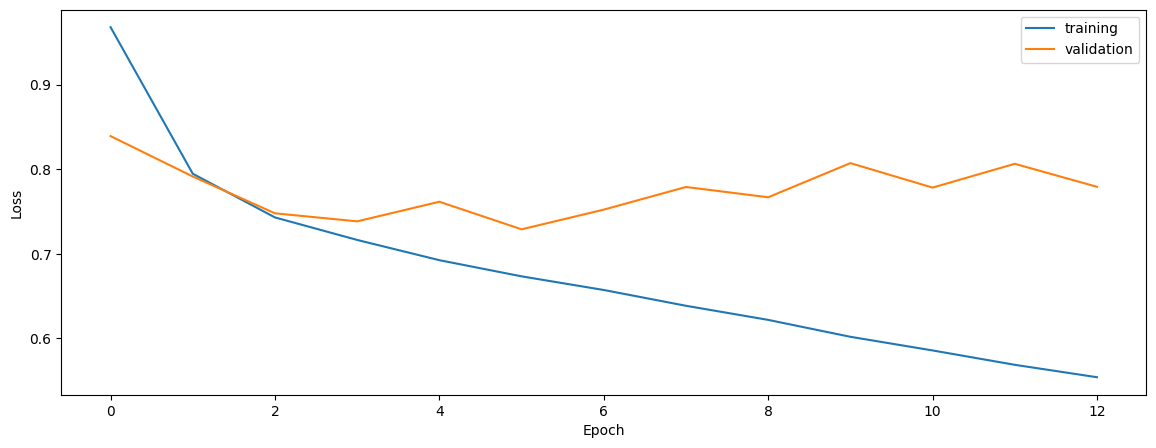

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7650041043741547
0.7439460264006029
0.7582577504422547


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized


0.7650041043741547
0.7439460264006029
0.7582577504422547


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native


0.7622386786292172
0.7554659149718632
0.7574386501367983


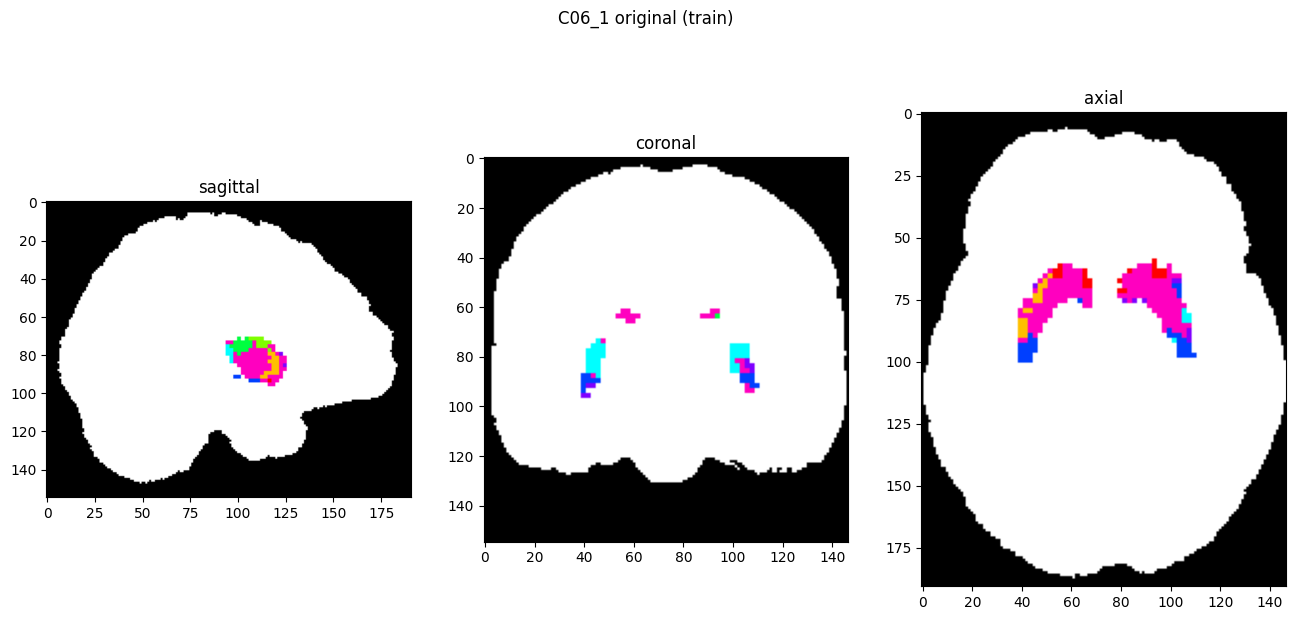

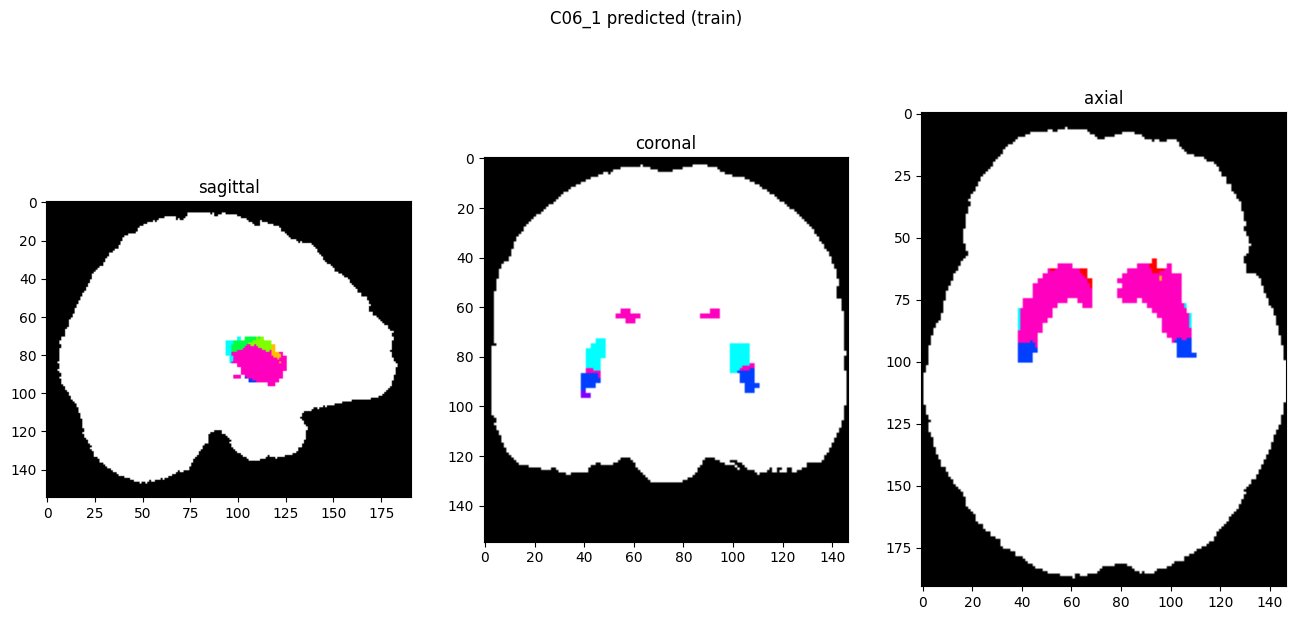

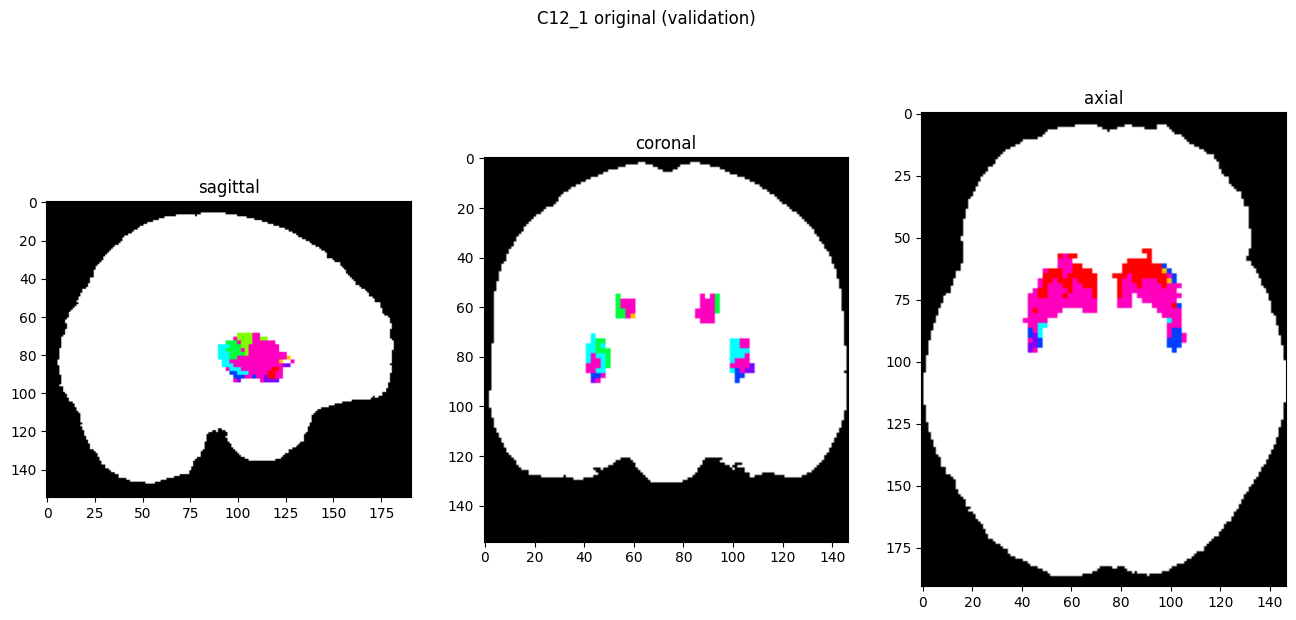

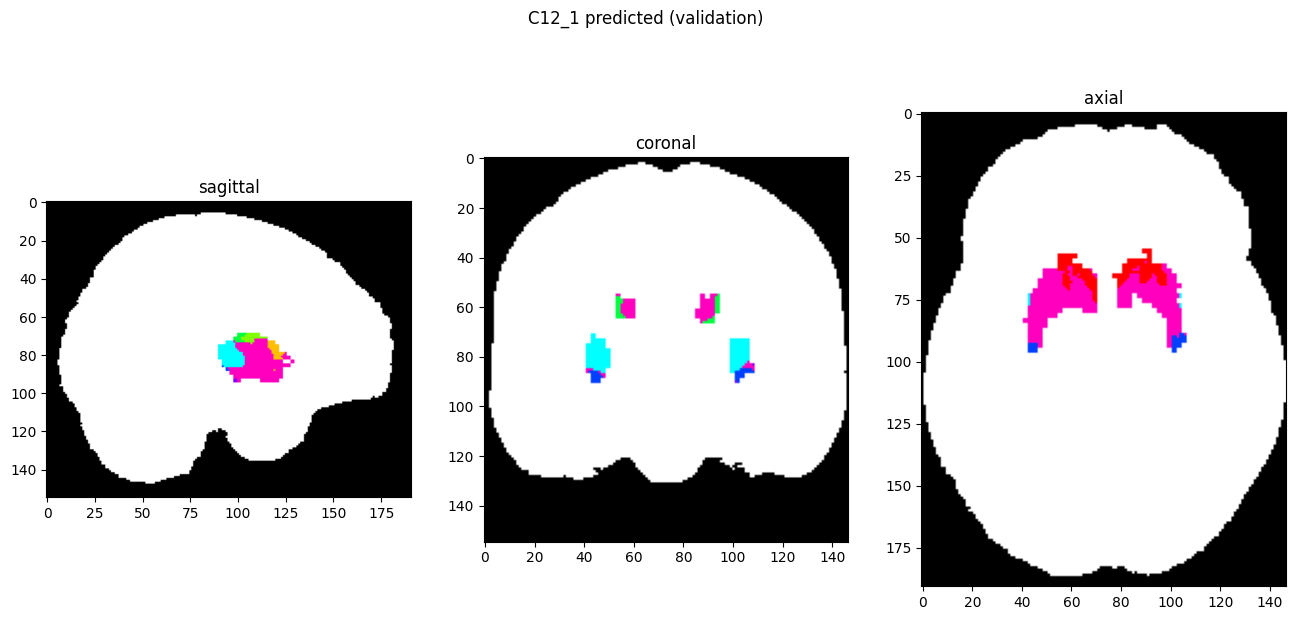

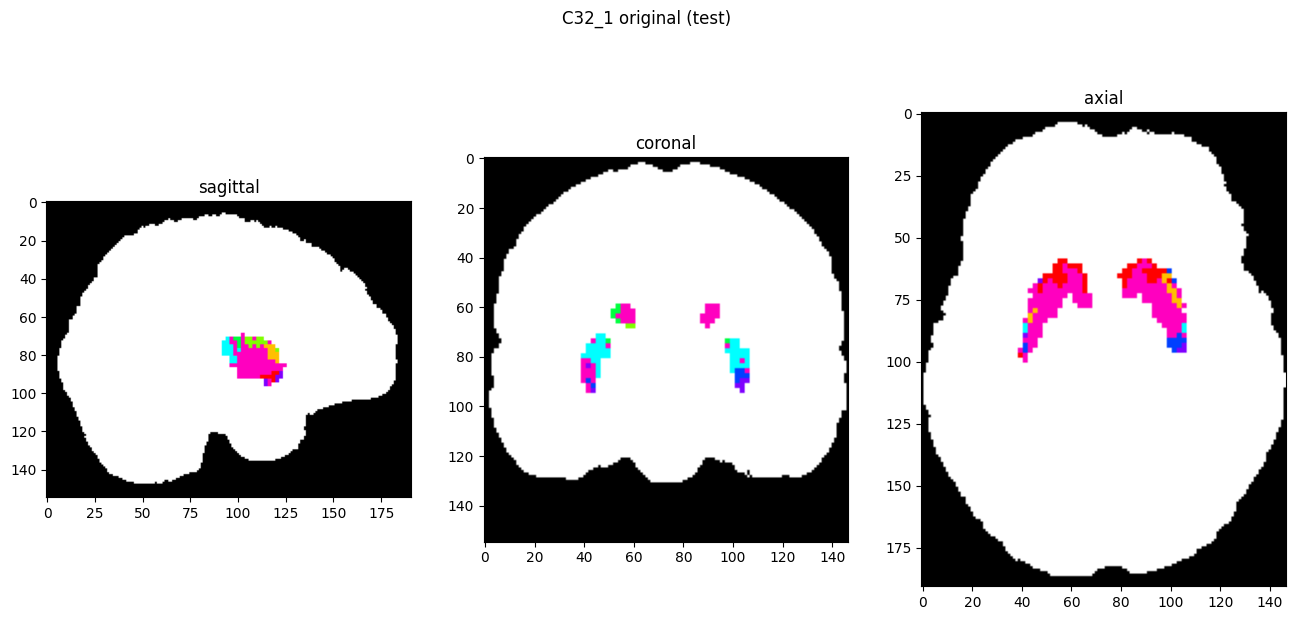

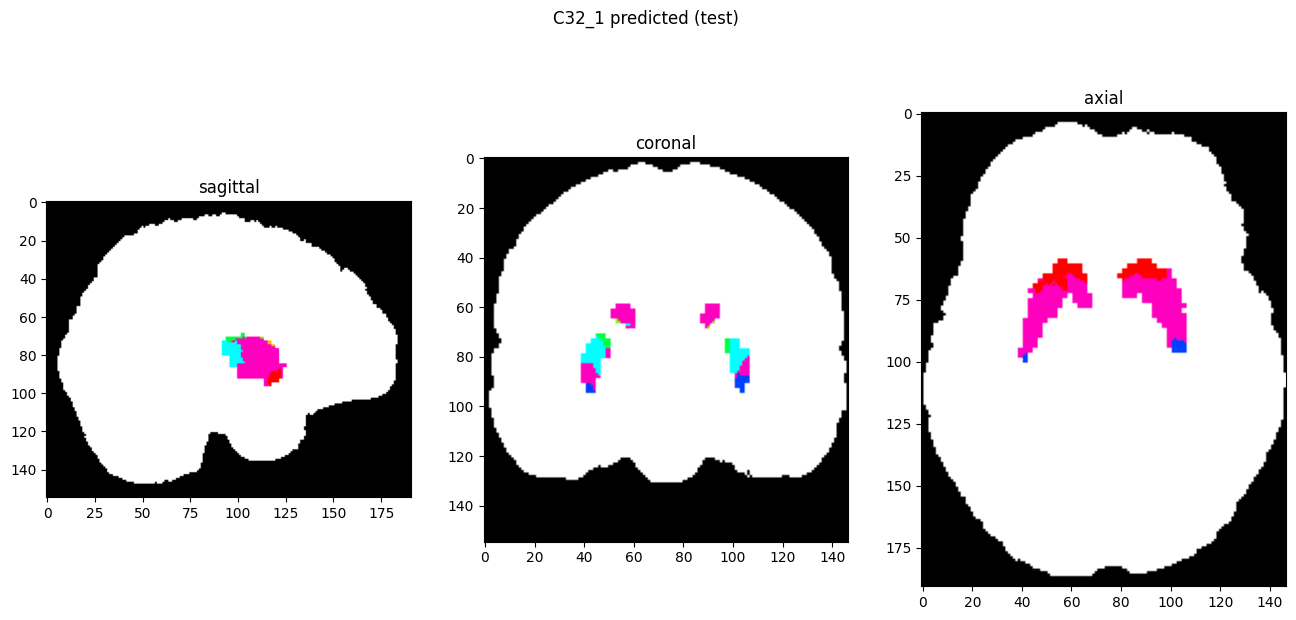

In [10]:
showResults(model, gen, threshold=0)